In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import hashlib
import random

WAVELET TRANSFORM

In [35]:
def Transform1(Image):

    Array = []

    for Row in Image:
        A = []
        D = []
        X = int(len(Row)/2)
        for i in range(X):
            Temp1 = (Row[2*i] + Row[2*i + 1])//2
            Temp2 = Row[2*i] - Row[2*i + 1]
            A.append(Temp1)
            D.append(Temp2)
        Temp = A + D
        Array.append(Temp)

    return Array


def Transform2(Image):

    Array = []

    for Row in Image:
        X = int(len(Row)/2)
        A = Row[:X]
        D = Row[X:]
        Temp = [0 for i in range(len(Row))]
        for i in range(X):
            Temp[2*i] = A[i] + (D[i]+1)//2
            Temp[2*i + 1] = Temp[2*i] - D[i]

        Array.append(Temp)

    return Array


def FWT(Image):

    W = np.array(Transform1(Image))
    X = W.T
    Y = np.array(Transform1(X))
    Z = Y.T
    return Z


def IWT(Image):
    A = Image.T
    B = np.array(Transform2(A))
    C = B.T
    D = np.array(Transform2(C))
    return D

FIND HISTOGRAM AND BEST POINT VALUES

In [36]:
def GetHistogram(Image):
    Histogram = np.zeros((256, 2), dtype=int)

    for Rows in Image:
        for PixelValue in Rows:
            Histogram[int(PixelValue)][0] += 1

    for i in range(256):
        Histogram[i][1] = i

    return Histogram


def FindPoint(Histogram, Templist, N):
    for i in range(len(Histogram)):
        if all(abs(Histogram[i][1] - x[1]) > 2 for x in Templist):
            if Histogram[i][0] >= N:
                Value = Histogram[i]
                break
    return Value


def GenerateList(Histogram):
    TempList1 = np.array(Histogram[::-1])
    TempList2 = []
    for value in TempList1:
        if all(abs(value[1] - x[1]) > 2 for x in TempList2):
            TempList2.append(value)
            if len(TempList2) == 3:
                break
    TempList3 = np.array(TempList2)
    return TempList3


def BestPoint(Histogram, N):

    TempList1 = [x for x in Histogram if x[1] < 254]

    Values = []

    if TempList1[-1][0] >= N:
        Temp = FindPoint(TempList1, Values, N)
        Values.append(Temp)

    else:

        TempList2 = GenerateList(TempList1)
        print("Best point values are : ", TempList2)

        if N <= TempList2[0][0] + TempList2[1][0]:
            Values.append(TempList2[0])
            X = N - TempList2[0][0]
            Temp = FindPoint(TempList1, Values, X)
            Values.append(Temp)

        elif N <= TempList2[0][0] + TempList2[1][0] + TempList2[2][0]:
            Values.append(TempList2[0])
            Values.append(TempList2[1])
            X = N - (TempList2[0][0] + TempList2[1][0])
            Temp = FindPoint(TempList1, Values, X)
            Values.append(Temp)

        else:
            print("SORRY, YOUR MESSAGE LENGTH EXCEEDS 3 BASE POINTS. INSUFFICIENTT SPACE.")
            return
    
    List = np.array(Values)

    return List

MESSAGE-BINARY & BINARY-MESSAGE CONVERSION

In [37]:
def MessageToBinary(Message):
    BinaryResult = ""
    for char in Message:
        AsciiValue = ord(char)
        BinaryValue = bin(AsciiValue)[2:]
        BinaryValue = BinaryValue.zfill(8)
        BinaryResult += BinaryValue
    return BinaryResult


def BinaryToMessage(BinaryString):
    Message = ""
    for i in range(0, len(BinaryString), 8):
        BinaryValue = BinaryString[i:i+8]
        AsciiValue = int(BinaryValue, 2)
        Character = chr(AsciiValue)
        Message += Character
    return Message


def ArrayToBinary(Array):
    TempList1 = Array.flatten()
    TempList2 = [format(pixel, '08b') for pixel in TempList1]
    
    BinaryMessage = ''.join(TempList2)
    return BinaryMessage


def BinaryToArray(BinaryString, Length, Breadth):
    TempList1 = []
    for i in range(0, len(BinaryString), 8):
        binary_value = BinaryString[i:i+8]
        number = int(binary_value, 2)
        TempList1.append(number)
    TempList2 = np.array(TempList1)
    Array = TempList2.reshape((Length, Breadth))
    return Array

ENCODE AND DECODE

In [38]:
def Encrypt(Image, Message, Value):

    m, n = Image.shape
    Len = len(Message)

    for i in range(m):
        for j in range(n):
            if Image[i][j] == (Value + 1):
                Image[i][j] += 1

    Counter = 0

    for i in range(m):
        for j in range(n):
            if Image[i][j] == Value:
                if Counter < Len:
                    Image[i][j] += int(Message[Counter])
                else:
                    Image[i][j] += 2
                Counter += 1


def Encode(Image, Message):

    m, n = Image.shape

    Histogram = GetHistogram(Image)

    SortedHistogram =  np.array(sorted(Histogram, key=lambda x: (x[0], x[1])))


    for i in range(256):
        if SortedHistogram[i][0] != 0:
            break

    SortedHistogram = SortedHistogram[i:]

    Values = BestPoint(SortedHistogram, len(Message))

    for Value in Values:
        Encrypt(Image, Message, Value[1])
        Message = Message[Value[0]:]

    return Image, Values


def Decode(Image, Value):

    m, n = Image.shape

    Message = ""
    for i in range(m):
        for j in range(n):
            if Image[i][j] == Value:
                Message = Message + '0'
            elif Image[i][j] == (Value+1):
                Message = Message + '1'
    return Message

ARNOLD'S CAT MAP

In [39]:
def SquareMatrix(Array):
    MaxDimension = max(Array.shape)
    NearestPowerOf2 = 2 ** int(np.ceil(np.log2(MaxDimension)))
    SquareMatrix = np.zeros((NearestPowerOf2, NearestPowerOf2), dtype=Array.dtype)
    SquareMatrix[:Array.shape[0], :Array.shape[1]] = Array
    
    return SquareMatrix


def ArnoldCatMap(Image, Iterations):

    Height, Width = Image.shape[:2]
    TransformedImage = np.zeros_like(Image)

    Counter = 0
    while Counter < Iterations:

        for x in range(Width):
            for y in range(Height):
                nx = (2 * x + y) % Width
                ny = (x + y) % Height
                TransformedImage[ny, nx] = Image[y, x]

        Image = TransformedImage.copy()

        Counter += 1

    return TransformedImage

FIND, EMBEDD & EXTRACT SHA-256

In [40]:
# def FindSHA(Image):
#     ImageBytes = Image.flatten()
#     SHA256Hash = hashlib.sha256(ImageBytes).hexdigest()
    
#     return SHA256Hash


def FindSHA(Image):
    ImageFlatten = Image.flatten()
    String = ""
    for i in ImageFlatten:
        String += str(i)

    SHA256Hash = hashlib.sha256(String.encode()).hexdigest()
    
    return SHA256Hash


def RandomSequence(Size):
    random.seed(Size)
    for i in range(Size):
        if i > 2:
            HCF = math.gcd(i, Size)
            if HCF == 1:
                break
    Number = random.randint(0, Size-1)
    Temp = Number
    Result = [Temp]
    while True:
        Number = (Number + i) % Size
        if Number == Temp:
            break
        Result.append(Number)
    return Result


def EmbeddSHA(Image, Message):
    BinaryMessage = MessageToBinary(Message)
    Sequence = RandomSequence(256)
    m, n = Image.shape
    i = 0
    while BinaryMessage != "":
        p = int(Sequence[i]/n)
        q = Sequence[i]%n
        Temp1 = Image[p][q]
        Temp2 = abs(Temp1)
        Temp3 = (Temp2 & 252) | int(BinaryMessage[:2], 2)
        Image[p][q] = -Temp3 if Temp2 < 0 else Temp3
        BinaryMessage = BinaryMessage[2:]
    return Image


def ExtractSHA(Image):
    BinaryMessage = ""
    Sequence = RandomSequence(256)
    m, n = Image.shape

    i = 0
    while len(BinaryMessage) != 512:
        p = int(Sequence[i]/n)
        q = Sequence[i]%n
        BinaryMessage = BinaryMessage +  bin(Image[p][q] & 3)[2:].zfill(2)
        i += 1

    Message = BinaryToMessage(BinaryMessage)
    return Message

HIDE & EXTRACT IMAGE

In [41]:
def Hide(CoverImage, WatermarkImage):
    p, q = CoverImage.shape[0] // 2, CoverImage.shape[1] // 2
    TransformedCoverImage = FWT(CoverImage)

    plt.imshow(TransformedCoverImage, cmap='gray')
    plt.axis('off')
    plt.title("The Transformed Cover Image")
    plt.show()

    ImageLL = TransformedCoverImage[:p, :q].copy()
    ImageHH = TransformedCoverImage[p:, q:].copy()

    x, y = WatermarkImage.shape
    WatermarkImage = SquareMatrix(WatermarkImage)
    SHA256Hash = FindSHA(WatermarkImage)
    UpdatedImageHH = EmbeddSHA(ImageHH, SHA256Hash)

    Size = WatermarkImage.shape[0]

    n = Size/2 + Size/4
    Iteration = int(n*0.77)
    ChaoticImage = ArnoldCatMap(WatermarkImage, Iteration)

    plt.imshow(ChaoticImage, cmap='gray')
    plt.axis('off')
    plt.title("The Chaotic Watermark Image")
    plt.show()

    Iteration = n - Iteration

    Message = ArrayToBinary(ChaoticImage)
    UpdatedImageLL, Values = Encode(ImageLL, Message)

    TransformedCoverImage[:p, :q] = UpdatedImageLL.copy()
    TransformedCoverImage[p:, q:] = UpdatedImageHH.copy()
    
    StegoImage = IWT(TransformedCoverImage)
    TempList = [Size, x, y, Iteration, Values]
    return StegoImage, TempList


def Extract(StegoImage, InfoList):

    Size, m, n, Iteration, Values = InfoList[0], InfoList[1], InfoList[2], InfoList[3], InfoList[4]

    p, q = StegoImage.shape[0] // 2, StegoImage.shape[1] // 2
    TransformedStegoImage = FWT(StegoImage)
    ImageLL = TransformedStegoImage[:p, :q]
    ImageHH = TransformedStegoImage[p:, q:]
    CodedSHA = ExtractSHA(ImageHH)

    Message = ""

    for Value in Values:
        Message = Message + Decode(ImageLL, Value[1])
    
    Array = np.array(BinaryToArray(Message, Size, Size))
    Array = ArnoldCatMap(Array, Iteration)
    SHA256Hash = FindSHA(Array)

    if CodedSHA == SHA256Hash:
        print("SHA Matched.")

    return Array

SAVE IMAGES

In [42]:
def SaveStego(Path1, Path2, Image, Flag):
    Title1 = os.path.splitext(os.path.split(Path1)[1])[0]
    Title2 = os.path.splitext(os.path.split(Path2)[1])[0]

    if Flag == 0:
        Directory = "StegoImages/"
        ImageName = "Stego_{Cover}_Coded_{Secret}.png"
    else:
        Directory = "SecretImages/"
        ImageName = "Extracted_{Secret}_From_{Cover}.png"

    Path = ImageName.format(Cover=Title1, Secret = Title2)
    FullPath = os.path.join(Directory, Path)
    cv2.imwrite(FullPath, Image)
    return FullPath

MAIN FUNCTION

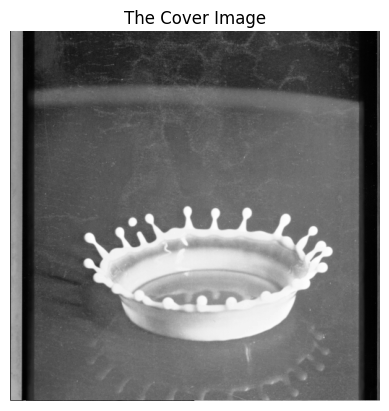

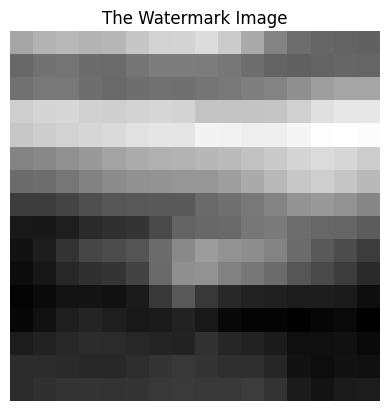

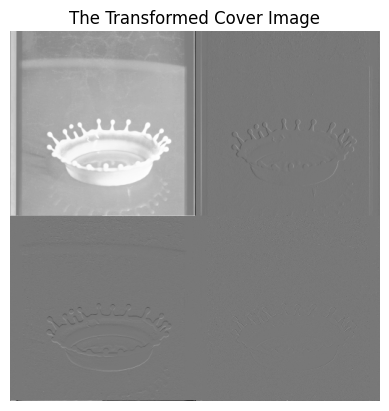

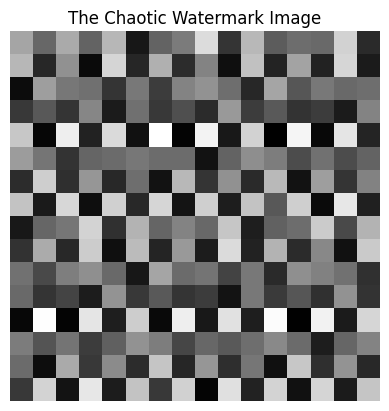

Best point values are :  [[1603  109]
 [1289  106]
 [1139  112]]


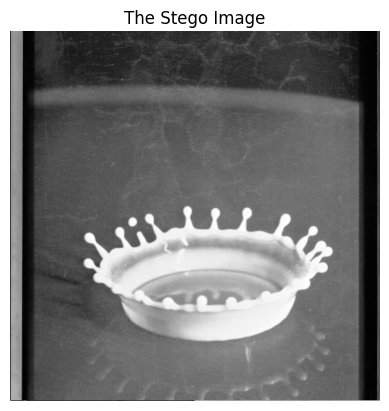

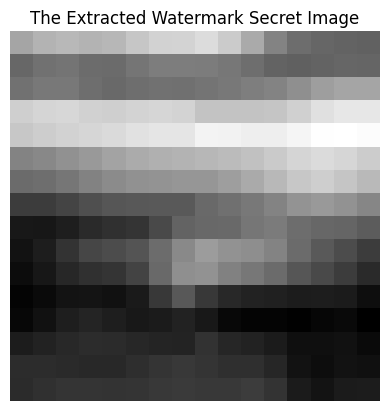

MSE :  0.04785919189453125
PSNR :  61.33114999618256


In [43]:
pepper = r"C:\Users\arnab\Desktop\PROJECT WORK\Peppers.tiff"
female = r"C:\Users\arnab\Desktop\PROJECT WORK\female.tiff"
splash = r"C:\Users\arnab\Desktop\PROJECT WORK\CoverImages\splash.tiff"
lena = r"C:\Users\arnab\Desktop\PROJECT WORK\CoverImages\lena.tiff"

Path1 = splash
CoverImage = cv2.imread(Path1, 0).astype(np.int32)

plt.imshow(CoverImage, cmap='gray')
plt.axis('off')
plt.title("The Cover Image")
plt.show()

Path2 = r"C:\Users\arnab\Desktop\PROJECT WORK\WatermarkImages\551-16x16-grayscale.jpg"
WatermarkImage = cv2.imread(Path2, 0)

plt.imshow(WatermarkImage, cmap='gray')
plt.axis('off')
plt.title("The Watermark Image")
plt.show()

StegoImage, Info = Hide(CoverImage.copy(), WatermarkImage.copy())

plt.imshow(StegoImage, cmap='gray')
plt.axis('off')
plt.title("The Stego Image")
plt.show()

Path = SaveStego(Path1, Path2, StegoImage, 0)
ReadStegoImage = cv2.imread(Path, 0).astype(np.int32)

SecretImage = Extract(ReadStegoImage, Info)
SaveStego(Path1, Path2, SecretImage, 1)

plt.imshow(SecretImage, cmap='gray')
plt.axis('off')
plt.title("The Extracted Watermark Secret Image")
plt.show()

MSE = np.mean((CoverImage - StegoImage) ** 2)
print("MSE : ", MSE)
x = cv2.PSNR(CoverImage, StegoImage)
print("PSNR : ", x)